In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from meteostat import Point, Hourly
from datetime import datetime
from pandas.api.types import CategoricalDtype

#set notebook options
pd.options.mode.chained_assignment = None 
pd.set_option('display.max_columns', None)
plt.rcParams.update({'font.size': 10})
sns.set_style("white")
plt_color = 'cadetblue'

In [2]:
# import bokeh for interactive plots
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, HoverTool, CategoricalColorMapper
from bokeh.palettes import Spectral6
from bokeh.transform import factor_cmap
from bokeh.layouts import gridplot

# import math
import math

# import bokeh panel and tabs

from bokeh.models import TabPanel, Tabs


output_notebook()

# save as html
from bokeh.io import output_file, save


Loading BokehJS ...

In [3]:
df = pd.read_csv('./Data/Motor_Vehicle_Collisions_Crashes.csv')

In [4]:
df['HOUR'] = pd.to_datetime(df['CRASH TIME'], format='%H:%M').dt.hour
df['MINUTE'] = pd.to_datetime(df['CRASH TIME'], format='%H:%M').dt.minute
df['CRASH DATE'] = pd.to_datetime(df['CRASH DATE'])
df['YEAR'] = df['CRASH DATE'].dt.year
df['MONTH'] = df['CRASH DATE'].dt.month
df['DAY'] = df['CRASH DATE'].dt.day
df['WEEKDAY'] = df['CRASH DATE'].dt.day_name()
dayorder = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['WEEKDAY'] = df['WEEKDAY'].astype(CategoricalDtype(categories=dayorder, ordered=True))
df['HOUR OF WEEK'] = df['CRASH DATE'].dt.dayofweek * 24 + (df.HOUR + 1).astype(int)

# drop data incomplete years
df = df[(df.YEAR > 2019) & (df.YEAR < 2024)]
df = df[(df.LONGITUDE != 0.000000) | (df.LATITUDE != 0.000000)]

#sort data on CRASH DATE
df = df.sort_values(by=['CRASH DATE']).reset_index(drop=True)

# keep data from 2017-2022
#df = df[(df['YEAR'] >= 2017) & (df['YEAR'] <= 2022)]

In [5]:
print(df.shape)

(348516, 36)


In [6]:
# count number of collisions with no injuries or fatalities
df['NO INJURIES'] = np.where(df['NUMBER OF PERSONS INJURED'] == 0, 1, 0)
df['NO FATALITIES'] = np.where(df['NUMBER OF PERSONS KILLED'] == 0, 1, 0)
df['NO INJURIES OR FATALITIES'] = np.where((df['NUMBER OF PERSONS INJURED'] == 0) & (df['NUMBER OF PERSONS KILLED'] == 0), 1, 0)

df.sum()

CRASH TIME                       3:303:352:454:502:164:4017:383:353:1211:009:40...
LATITUDE                                                            13037427.90262
LONGITUDE                                                         -23662502.940491
NUMBER OF PERSONS INJURED                                                 159546.0
NUMBER OF PERSONS KILLED                                                     896.0
NUMBER OF PEDESTRIANS INJURED                                                25293
NUMBER OF PEDESTRIANS KILLED                                                   381
NUMBER OF CYCLIST INJURED                                                    16367
NUMBER OF CYCLIST KILLED                                                        77
NUMBER OF MOTORIST INJURED                                                  112962
NUMBER OF MOTORIST KILLED                                                      404
COLLISION_ID                                                         1548710925824
HOUR

In [7]:
df_orig = df.copy()

In [8]:
df = df_orig
df.shape

(348516, 39)

I want a plot where the focus is on the factor. It should be grouped by severity (material damage, injured and killed), type of transportation (motorist, cyclist, pedestrian) and borough.

In [9]:
# create columns that indicate if only material damage, injuries or fatalities occured
df['MATERIAL DAMAGE'] = np.where((df['NUMBER OF PERSONS INJURED'] == 0) & (df['NUMBER OF PERSONS KILLED'] == 0), 1, 0)
df['INJURIES'] = np.where((df['NUMBER OF PERSONS INJURED'] > 0) & (df['NUMBER OF PERSONS KILLED'] == 0), 1, 0)
df['FATALITIES'] = np.where((df['NUMBER OF PERSONS INJURED'] >= 0) & (df['NUMBER OF PERSONS KILLED'] > 0), 1, 0)


# the sum of MATERIAL DAMAGE, INJURIES and FATALITIES should be equal to df.shape = 235763
df['MATERIAL DAMAGE'].sum() + df['INJURIES'].sum() + df['FATALITIES'].sum()


348515

In [ ]:
# categorize collisions two fold: by type and severity

In [10]:
# categorize data depending on whether a motorist, cyclist, or pedestrian was involved
df["PEDESTRIAN_INJURED"] = np.where(df["NUMBER OF PEDESTRIANS INJURED"] > 0, 1, 0)
df["PEDESTRIAN_KILLED"] = np.where(df["NUMBER OF PEDESTRIANS KILLED"] > 0, 1, 0)
df["CYCLIST_INJURED"] = np.where(((df["NUMBER OF CYCLIST INJURED"] > 0) & (df["PEDESTRIAN_INJURED"] <= 0)), 1, 0)
df["CYCLIST_KILLED"] = np.where(((df["NUMBER OF CYCLIST KILLED"] > 0) & (df["PEDESTRIAN_KILLED"] <= 0)), 1, 0)
df["MOTORIST_INJURED"] = np.where((df["NUMBER OF MOTORIST INJURED"] > 0) & (df["CYCLIST_INJURED"] == 0) & (df["PEDESTRIAN_INJURED"] == 0), 1, 0)
df["MOTORIST_KILLED"] = np.where((df["NUMBER OF MOTORIST KILLED"] > 0) & (df["CYCLIST_KILLED"] == 0) & (df["PEDESTRIAN_KILLED"] == 0), 1, 0)


df.sum()


CRASH TIME                       3:303:352:454:502:164:4017:383:353:1211:009:40...
LATITUDE                                                            13037427.90262
LONGITUDE                                                         -23662502.940491
NUMBER OF PERSONS INJURED                                                 159546.0
NUMBER OF PERSONS KILLED                                                     896.0
NUMBER OF PEDESTRIANS INJURED                                                25293
NUMBER OF PEDESTRIANS KILLED                                                   381
NUMBER OF CYCLIST INJURED                                                    16367
NUMBER OF CYCLIST KILLED                                                        77
NUMBER OF MOTORIST INJURED                                                  112962
NUMBER OF MOTORIST KILLED                                                      404
COLLISION_ID                                                         1548710925824
HOUR

In [150]:
#df["PEDESTRIAN_KILLED"].sum()+df["PEDESTRIAN_INJURED"].sum()+df["CYCLIST_KILLED"].sum()+df["CYCLIST_INJURED"].sum()+df["MOTORIST_KILLED"].sum()+df["MOTORIST_INJURED"].sum()

206739

In [11]:
# make three dataframes for material damage, injuries and fatalities
df_material_damage = df[['CONTRIBUTING FACTOR VEHICLE 1', 'MATERIAL DAMAGE']].groupby('CONTRIBUTING FACTOR VEHICLE 1').sum().reset_index()
df_injured = df[['CONTRIBUTING FACTOR VEHICLE 1', 'MOTORIST_INJURED', 'CYCLIST_INJURED', 'PEDESTRIAN_INJURED']].groupby('CONTRIBUTING FACTOR VEHICLE 1').sum().reset_index()
df_killed = df[['CONTRIBUTING FACTOR VEHICLE 1', 'MOTORIST_KILLED', 'CYCLIST_KILLED', 'PEDESTRIAN_KILLED']].groupby('CONTRIBUTING FACTOR VEHICLE 1').sum().reset_index()


In [12]:
from bokeh.models.callbacks import CustomJS
import os

In [24]:
# sort the df by the sum of the three categories
df_injured['sum'] = df_injured['MOTORIST_INJURED'] + df_injured['CYCLIST_INJURED'] + df_injured['PEDESTRIAN_INJURED']
df_killed['sum'] = df_killed['MOTORIST_KILLED'] + df_killed['CYCLIST_KILLED'] + df_killed['PEDESTRIAN_KILLED']
df_injured = df_injured.sort_values(by=['sum'], ascending=True)
df_killed = df_killed.sort_values(by=['sum'], ascending=True)
df_material_damage = df_material_damage.sort_values(by=['MATERIAL DAMAGE'], ascending=True)

# drop the rows with 'Unspecified' as the contributing factor
df_injured = df_injured[df_injured['CONTRIBUTING FACTOR VEHICLE 1'] != 'Unspecified']
df_killed = df_killed[df_killed['CONTRIBUTING FACTOR VEHICLE 1'] != 'Unspecified']
df_material_damage = df_material_damage[df_material_damage['CONTRIBUTING FACTOR VEHICLE 1'] != 'Unspecified']

# only keep the top 8 contributing factors
df_injured = df_injured.tail(8)
df_killed = df_killed.tail(8)
df_material_damage = df_material_damage.tail(8)


# create a ColumnDataSource object for each category
source_material_damage = ColumnDataSource(df_material_damage)
source_injured = ColumnDataSource(df_injured)
source_killed = ColumnDataSource(df_killed)

# create a figure object for each category
# the figures are displayed on an html page and should scale with the window size
p_material_damage = figure(y_range=df_material_damage['CONTRIBUTING FACTOR VEHICLE 1'], height=500, width=750, title='Most Frequent Contributing Factors for Material Damage', toolbar_location=None, tools='')
p_injured = figure(y_range=df_injured['CONTRIBUTING FACTOR VEHICLE 1'], height=500, width=750, title='Most Frequent Contributing Factors for Injured', toolbar_location=None, tools='')
p_killed = figure(y_range=df_killed['CONTRIBUTING FACTOR VEHICLE 1'], height=500, width=750, title='Most Frequent Contributing Factors for Killed', toolbar_location=None, tools='')
#p_material_damage.xaxis.major_label_orientation = math.pi/2
#p_injured.xaxis.major_label_orientation = math.pi/2
#p_killed.xaxis.major_label_orientation = math.pi/2

# remove x < 0 axis
p_material_damage.x_range.start = 0
p_injured.x_range.start = 0
p_killed.x_range.start = 0

# specify pleasent colors for each category
#colors = ["#4271AE", "#F5A623", "#4CAF50"]
colors = ["#4c8f7e", "#7fb9b3", "#ff5d49"]



# create a stacked bar plot for each category
p_material_damage.hbar(y='CONTRIBUTING FACTOR VEHICLE 1', left=0, right='MATERIAL DAMAGE', height=0.8, color=colors[0], source=source_material_damage)
p_injured.hbar_stack(['MOTORIST_INJURED', 'CYCLIST_INJURED', 'PEDESTRIAN_INJURED'], y='CONTRIBUTING FACTOR VEHICLE 1', height=0.8, color=colors, source=source_injured, legend_label=['Motorist', 'Cyclist', 'Pedestrian'])
p_killed.hbar_stack(['MOTORIST_KILLED', 'CYCLIST_KILLED', 'PEDESTRIAN_KILLED'], y='CONTRIBUTING FACTOR VEHICLE 1', height=0.8 , color=colors, source=source_killed, legend_label=['Motorist', 'Cyclist', 'Pedestrian'])

# add hover tool to each figure
hover_material_damage = HoverTool(tooltips=[('Contributing Factor', '@{CONTRIBUTING FACTOR VEHICLE 1}'), ('Material Damage', '@{MATERIAL DAMAGE}')])
hover_injured = HoverTool(tooltips=[('Contributing Factor', '@{CONTRIBUTING FACTOR VEHICLE 1}'), ('Motorist', '@{MOTORIST_INJURED}'), ('Cyclist', '@{CYCLIST_INJURED}'), ('Pedestrian', '@{PEDESTRIAN_INJURED}')])
hover_killed = HoverTool(tooltips=[('Contributing Factor', '@{CONTRIBUTING FACTOR VEHICLE 1}'), ('Motorist', '@{MOTORIST_KILLED}'), ('Cyclist', '@{CYCLIST_KILLED}'), ('Pedestrian', '@{PEDESTRIAN_KILLED}')])

p_material_damage.add_tools(hover_material_damage)
p_injured.add_tools(hover_injured)
p_killed.add_tools(hover_killed)

# add legend to each figure
p_injured.legend.location = 'bottom_right'
p_injured.legend.orientation = 'horizontal'
p_killed.legend.location = 'bottom_right'
p_killed.legend.orientation = 'horizontal'

# create tabs for each category
tab_material_damage = TabPanel(child=p_material_damage, title='Material Damage')
tab_injured = TabPanel(child=p_injured, title='Injured')
tab_killed = TabPanel(child=p_killed, title='Killed')

# create a Tabs object with the two tabs
# the Tabs object is displayed on an html page and should scale with the window size
#tabs = Tabs(tabs=[tab_material_damage, tab_injured, tab_killed], sizing_mode='scale_width')
tabs = Tabs(tabs=[tab_material_damage, tab_injured, tab_killed])

#show(tabs)

"In this plot all t"

callback = CustomJS(code="""
    var tab_content = document.getElementById('tab-content');
    var selected_tab = cb_obj.active;
    
    var markdown_content = '';
    if (selected_tab == 0) {
    markdown_content = `Driver inattention/distraction is the leading contributing factor in material damage-only accidents, accounting for over 54,681 crashes. This is likely due to the fact that a split second of inattention can easily lead to subsequent actions that result in a collision with another car or object. 
    Following too closely is the second most common contributing factor, with approximately 14,369 accidents. Other common factors include passing too closely, improper passing or lane usage, backing unsafely, and failure to yield right-of-way. These factors may result from various causes, such as drivers attempting to pass or change lanes without signaling or checking blind spots, or backing up in areas with limited visibility. They may also occur when drivers misjudge the speed or distance of other vehicles, fail to properly anticipate their movements, or use lanes inappropriately. By identifying these factors and developing targeted strategies to reduce their occurrence, we can improve traffic safety and reduce the number of material damage-only accidents.`;
    } else if (selected_tab == 1) {
    markdown_content = `This plot builds on the previous one, but adds an important dimension by breaking down the crashes based on whether they resulted in injuries to motorists, cyclists, or pedestrians. The data reveals some important takeaways about the contributing factors in these accidents.

Firstly, as with the previous plot, Driver Inattention/Distraction remains the leading cause of accidents resulting in injuries, with the majority of injuries occurring amongst motorists. This suggests that distracted driving is a significant risk factor for all road users.

Secondly, failure to yield right-of-way emerges as the second most common contributing factor, with the distribution of injuries skewed towards pedestrians. This indicates that pedestrians are particularly vulnerable to accidents involving vehicles that fail to yield right-of-way, and underscores the importance of designing roads and intersections with pedestrian safety in mind.

Finally, following too closely emerges as the third most common contributing factor, but it almost exclusively leads to injuries amongst motorists. This suggests that tailgating and other forms of aggressive driving behavior are particularly dangerous for those inside vehicles, and highlights the need for increased education and enforcement efforts around safe driving practices.

Overall, this plot provides a more nuanced view of the contributing factors to accidents, highlighting the specific risks faced by different road users and emphasizing the need for targeted interventions to improve road safety.`;
    } else if (selected_tab == 2) {
    markdown_content = `This plot breaks down the contributing factors to fatal crashes based on whether the victim was a motorist, cyclist, or pedestrian. The top contributing factors are unsafe speed, driver inattention/distraction (with a majority of pedestrian deaths), and failure to yield right of way (with a majority of pedestrian deaths). Other common factors include traffic control disregarded, errors or confusion on the part of non-motorist road users, alcohol involvement, driver inexperience, and loss of consciousness. Addressing these issues requires a comprehensive approach that targets a range of contributing factors, from driver behavior to road design and infrastructure, and involves collaboration between policymakers, law enforcement agencies, transportation professionals, and the general public.`;
    }
    tab_content.innerHTML = markdown_content;
""")
                    
# we should use the markdownify to render the markdown content
# but for now js does not support the output of the markdownify...

# add the callback to the tabs
tabs.js_on_change('active', callback)


from bokeh.embed import file_html
from bokeh.resources import CDN
html = file_html(tabs, CDN, False)

# write the HTML code to the file
with open("/Users/jenspt/Desktop/git/socialdata2023/docs/_includes/factor_plot.html", "w") as f:
    f.write(html)


# show the plot
#output_file('material_damage.html', mode='inline')



We can look into what the most common factors are when two motorists are involved in an accident.

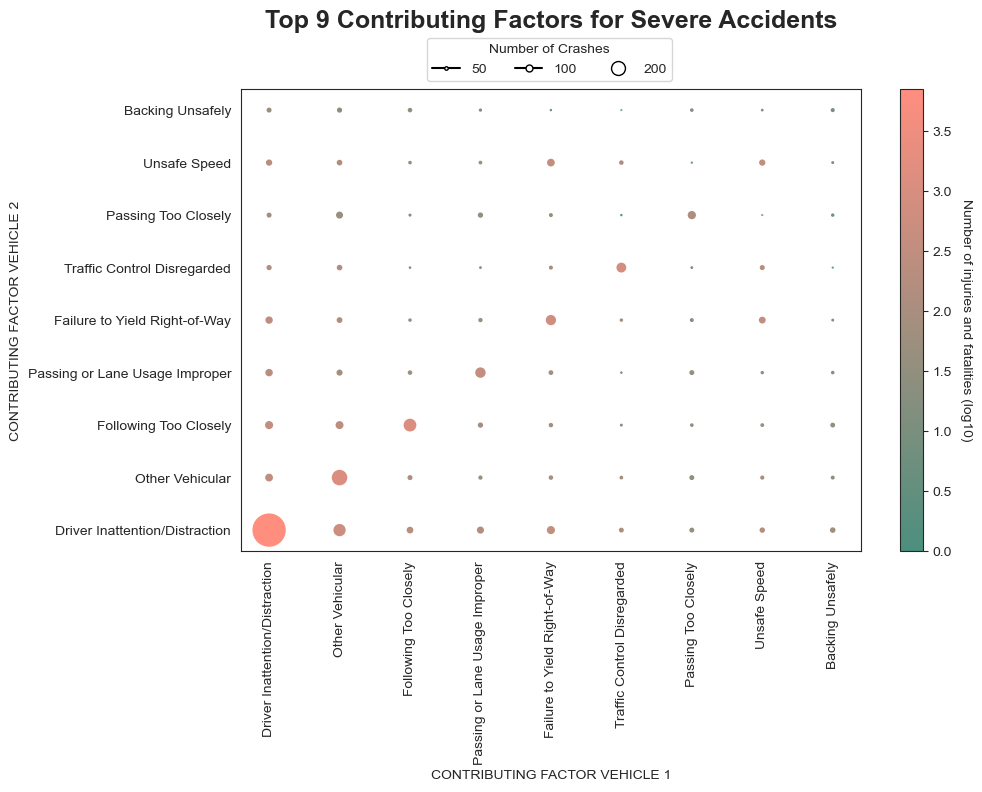

In [29]:
# select only top 8 contributing factors for vehicle 1 and 2
top_8 = df.groupby('CONTRIBUTING FACTOR VEHICLE 1').size().sort_values(ascending=False).head(10).index



df_tmp = df[df['CONTRIBUTING FACTOR VEHICLE 1'].isin(top_8) & df['CONTRIBUTING FACTOR VEHICLE 2'].isin(top_8)]

#calculate the number of fatalaties
df_tmp['FATALITIES'] = df_tmp['NUMBER OF PERSONS INJURED'] + df_tmp['NUMBER OF PERSONS KILLED']



# remove 'Unspecified' from contributing factor vehicle 1 and 2
df_tmp = df_tmp[df_tmp['CONTRIBUTING FACTOR VEHICLE 1'] != 'Unspecified']
df_tmp = df_tmp[df_tmp['CONTRIBUTING FACTOR VEHICLE 2'] != 'Unspecified']

# calculate the number of crashes and fatalities for each combination of contributing factors
df_tmp = df_tmp.groupby(['CONTRIBUTING FACTOR VEHICLE 1', 'CONTRIBUTING FACTOR VEHICLE 2']).agg({'CRASH DATE': 'count', 'FATALITIES': 'sum'}).reset_index()

#log transform the fatalities
df_tmp['FATALITIES'] = np.log10(df_tmp['FATALITIES'] + 1)

# plot the top 8 contributing factor vechile 1 and 2 against each other as a scatter plot where each point is a crash,
#  make the size of the point proportional to the number of crashes
#  and make the color of the point proportional to the number of fatalities
#  choose a color palette that goes from green to red

from matplotlib import colors as mcolors
# define the colors of the custom colormap
colors = ['#4c8f7e', '	#ff5d49']

# create a custom colormap using ListedColormap
#custom_cmap = mcolors.ListedColormap(colors)
custom_cmap = mcolors.LinearSegmentedColormap.from_list('custom', colors)


fig, ax = plt.subplots(figsize=(10,6))
# plot the scatter plot
# sort the x and y axis by the number of crashes
df_tmp = df_tmp.sort_values(by=['CRASH DATE'], ascending=False)
ax.scatter(df_tmp['CONTRIBUTING FACTOR VEHICLE 1'], df_tmp['CONTRIBUTING FACTOR VEHICLE 2'], s=df_tmp['CRASH DATE']/20, c=df_tmp['FATALITIES'], cmap=custom_cmap)
ax.set_xlabel('CONTRIBUTING FACTOR VEHICLE 1')
ax.set_ylabel('CONTRIBUTING FACTOR VEHICLE 2')
# add more padding between plot and title
ax.set_title('Top 9 Contributing Factors for Severe Accidents\n\n', weight='bold', fontsize=18)

# add a legend for the color of the points
sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=plt.Normalize(vmin=df_tmp['FATALITIES'].min(), vmax=df_tmp['FATALITIES'].max()))
sm._A = []
cbar = plt.colorbar(sm)
cbar.set_label('Number of injuries and fatalities (log10)', rotation=270, labelpad=15)

# add a legend for the size of the points to the plot
handles, labels = ax.get_legend_handles_labels()
handles = [plt.Line2D([0,0],[0,0], color='k', marker='o', markersize=50/20, markerfacecolor='w', markeredgecolor='k', label='50'),
           plt.Line2D([0,0],[0,0], color='k', marker='o', markersize=100/20, markerfacecolor='w', markeredgecolor='k', label='100'),
    plt.Line2D([0,0],[0,0], color='w', marker='o', markersize=200/20, markerfacecolor='w', markeredgecolor='k', label='200'),]
#place legend outside of plot between title and plot
# make legend horizontal instead of vertical

ax.legend(handles=handles, loc='upper left', title='Number of Crashes', bbox_to_anchor=(0.3, 1.11), borderaxespad=0., ncol=3)





#rotate the x axis labels
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
plt.show()

# save the plot as a png file
fig.savefig('/Users/jenspt/Desktop/git/socialdata2023/docs/assets/top_8_contributing_factors.png', bbox_inches='tight')

In [250]:
df_tmp

,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CRASH DATE,FATALITIES
10,Driver Inattention/Distraction,Driver Inattention/Distraction,10582,3.851931
40,Other Vehicular,Other Vehicular,2076,3.080266
30,Following Too Closely,Following Too Closely,1346,3.056142
37,Other Vehicular,Driver Inattention/Distraction,1224,2.752816
60,Passing or Lane Usage Improper,Passing or Lane Usage Improper,843,2.571709
...,...,...,...,...
18,Failure to Yield Right-of-Way,Backing Unsafely,10,0.477121
53,Passing Too Closely,Unsafe Speed,8,0.602060
7,Backing Unsafely,Traffic Control Disregarded,7,0.477121
77,Unsafe Speed,Passing Too Closely,5,1.079181
